# Training and evaluation notebook for Alexnet based Brevis Model.
<HR>
Models are trained on the CIFAR10 dataset, and uses CIFAR100 as an OOD dataset. <br>
    2 models are trained, one with branches using BrevisEnergy Loss and one using Cross entropy for all exits. <br>
    
    


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os
from keras_flops import get_flops 
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### load datasets

<hr>

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


## Initialize functions for building the loss functions 
<hr>

In [4]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)

class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_accuracy')+logs.get('branch_exit_1_accuracy'))
        

In [5]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)

def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost

## Build the Model
<hr>

In [6]:
base_model = tf.keras.models.load_model("./models/alexNetv6_adam.hdf5")
# Calculae FLOPS
print(base_model.outputs)
flops = get_flops(base_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")


[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 1.45 G


In [6]:
base_model.fit(train_ds, validation_data=validation_ds,epochs =3,)

Epoch 1/3
1407/1407 [==============================] - 65s 42ms/step - loss: 0.3253 - accuracy: 0.9027 - val_loss: 0.6354 - val_accuracy: 0.8000
Epoch 2/3
1407/1407 [==============================] - 63s 43ms/step - loss: 0.3021 - accuracy: 0.9086 - val_loss: 0.7048 - val_accuracy: 0.7666
Epoch 3/3
   4/1407 [..............................] - ETA: 1:15 - loss: 0.2312 - accuracy: 0.9297 

KeyboardInterrupt: 

In [8]:
model = tf.keras.models.load_model("./models/alexNetv6_adam.hdf5")
model.evaluate(test_ds)
model.compile(loss=[trunk_loss,branch_loss, branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
               metrics=['accuracy'])
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True)

# model.fit(train_ds,validation_data= validation_ds, epochs =60, callbacks=[earlyStop])
model.summary()


313/313 [==============================] - 6s 14ms/step - loss: 0.7665 - accuracy: 0.7799
Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 256)       614656    
                                   

In [28]:
# model.save("./models/alexNetv6_extraTrained.hdf5")

In [7]:
model = tf.keras.models.load_model("./models/alexNetv6_extraTrained.hdf5")
model.evaluate(validation_ds)

157/157 [==============================] - 2s 14ms/step - loss: 0.9661 - accuracy: 0.8218


[0.9661306738853455, 0.8217999935150146]

In [6]:

def MAEBM(lambda_callback: lambda_update):
    import tensorflow_probability as tfp
    def MAEBM_loss(labels, outputs):
        n_classes=10
        # evidence = tf.nn.softplus(outputs)
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        soft_output= labels
        S = tf.reduce_sum(alpha,axis=1,keepdims=True)
        alpha_0 = S * tf.ones((outputs.shape[-1]))
        UCE_loss = tf.reduce_mean(
            tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
        )
        annealing_coef =  lambda_callback.lambda_t
        
        
        bool_mask = tf.cast(outputs,tf.bool)
        ic_mask = tf.cast(1 - labels,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        dirichlet_weight = 0.0001 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
        UCE_loss = (
            UCE_loss + dirichlet_weight + info_reg
        )
        return UCE_loss
    return MAEBM_loss


def IAD_loss(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    
    def IAD(labels, logits):
        evidence = tf.nn.softplus(logits)
        # evidence = exp_evidence(logits)
        alpha = evidence + 1
        p = 4
        annealing_coef =  lambda_callback.lambda_t
        
        prob_c  = evidence * labels
        ic_mask = tf.cast(1 - labels,tf.float32)
        A = (1-tf.reduce_sum(prob_c,axis=1)) ** p
        B = tf.reduce_sum((ic_mask * evidence) ** p, axis=1)
        loss = (A + B) ** (1/p)
        
        
        
        bool_mask = tf.cast(labels,tf.bool)
        ic_mask = tf.cast(1 - labels,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        
#         A_ = (tf.exp(tf.math.lgamma(tf.reduce_sum(alpha,axis=1)))) / (tf.exp(tf.math.lgamma(tf.reduce_sum(alpha,axis=1)+p))) 
#         A_ = A_ ** (1/p)
        
#         B1_ = (tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked + p,axis=1)))) / tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked,axis=1)))
#         B2_ = tf.reduce_sum(tf.exp(tf.math.lgamma(ic_alpha_masked + p)),axis=1) / tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked,axis=1))) 
#         B_ = (B1_ + B2_) ** (1/p)
#         loss = A_ * B_
        
        
        
#         bool_mask = tf.cast(labels,tf.bool)
#         ic_mask = tf.cast(1 - labels,tf.bool)
#         ic_bool_mask = tf.cast(ic_mask,tf.bool)
#         ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5 * tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg)
        
        # annealing_coef =  0.0001
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return loss + info_reg + D  #+ info_reg #+ C + D
    return IAD   


## Branch the model
First we will train the BrevisNet version of the model with BrevisEnergy loss
<hr>

In [11]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


In [7]:
def _branch_CDL(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        Branch Design with just a single Linear classifier, based on the implementation of CDL.
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    output = keras.layers.Dense(10,  name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output


# def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
#     """ Add a new branch to a model connecting at the output of prevLayer. 
#         NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
#     """ 
#     branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
#     # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
#     # branchLayer = keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
#     # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
#     # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
#     # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     # branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
#     # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
#     # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
#     # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
#     # branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
#     # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
#     # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
#     return output


def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output



In [8]:
import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
tf.keras.backend.clear_session()

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(C)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     


growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# MSE_loss = tf.keras.losses.MeanSquaredError()

# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
earlyStop = _earlyStopping(monitor=["val_dense_11_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=5,restore_best_weights=True)
model = brevis.BranchModel(name="./models/alexNetv6_adam.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)


model.add_branches([_branch_conv1],
                          ["max_pooling2d_9",
                            # "conv2d_17",
                            # "conv2d_18",
                           # "max_pooling2d_11",
                            # "dense_9",
                          ],
                          target_input=False,loop=False,num_outputs=10)
model.setTrainable(True)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.summary()



NameError: name '_earlyStopping' is not defined

In [18]:
model.summary()

Model: "alexnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 54, 54, 96)   34944       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 54, 54, 96)  384         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [20]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            # [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("dense_11").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.225 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>]
FLOPS: 1.47 G


In [20]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_11").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.269 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 1.12 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>]
FLOPS: 1.54 G


In [14]:

model.fit(train_ds, epochs = 60, validation_data=validation_ds,transfer=True,callbacks=[growth_callback,earlyStop])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 61s 39ms/step - loss: 1.5612 - dense_11_loss: 0.3557 - branch_exit_loss: 0.6101 - branch_exit_1_loss: 0.5955 - dense_11_accuracy: 0.9009 - branch_exit_accuracy: 0.5298 - branch_exit_1_accuracy: 0.5367 - val_loss: 1.6658 - val_dense_11_loss: 0.7230 - val_branch_exit_loss: 0.4800 - val_branch_exit_1_loss: 0.4628 - val_dense_11_accuracy: 0.7912 - val_branch_exit_accuracy: 0.6476 - val_branch_exit_1_accuracy: 0.6670
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 59s 40ms/step - loss: 1.3659 - dense_11_loss: 0.3553 - branch_exit_loss: 0.5139 - branch_exit_1_loss: 0.4966 - dense_11_accuracy: 0.8989 - branch_exit_accuracy: 0.6818 - branch_exit_1_accuracy: 0.6865 - val_loss: 1.6576 - val_dense_11_loss: 0.7230 - val_branch_exit_loss: 0.4720 - val_branch_exit_1_loss: 0.4626 - val_dense_11_accuracy: 0.7912 - v

In [11]:

model.fit(train_ds, epochs = 15, validation_data=validation_ds,transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/15
1407/1407 [==============================] - 62s 38ms/step - loss: 1.5185 - dense_11_loss: 0.3533 - branch_exit_loss: 0.5725 - branch_exit_1_loss: 0.5927 - dense_11_accuracy: 0.8994 - branch_exit_accuracy: 0.5591 - branch_exit_1_accuracy: 0.5380 - val_loss: 1.6449 - val_dense_11_loss: 0.7230 - val_branch_exit_loss: 0.4758 - val_branch_exit_1_loss: 0.4461 - val_dense_11_accuracy: 0.7912 - val_branch_exit_accuracy: 0.6550 - val_branch_exit_1_accuracy: 0.6718
annealing coef updated to: 0.01
Epoch 2/15
1407/1407 [==============================] - 58s 40ms/step - loss: 1.3597 - dense_11_loss: 0.3547 - branch_exit_loss: 0.5068 - branch_exit_1_loss: 0.4982 - dense_11_accuracy: 0.8991 - branch_exit_accuracy: 0.6808 - branch_exit_1_accuracy: 0.6866 - val_loss: 1.6919 - val_dense_11_loss: 0.7230 - val_branch_exit_loss: 0.4670 - val_branch_exit_1_loss: 0.5020 - val_dense_11_accuracy: 0.7912 - v

In [19]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()
# model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
# model = keras.models.load_model("../models/alexNetv6_logits.hdf5")
growth_callback = growth_update(200,0.,max_t = 1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        # bool_mask = tf.cast(p,tf.bool)
        # ic_mask = tf.cast(1 - p,tf.bool)
        # ic_bool_mask = tf.cast(ic_mask,tf.bool)
        # ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        # #### info reg
        # _A = (ic_alpha_masked -1) ** 2
        # B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        # B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        # _B = (B_1 - B_2)
        # info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        # info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B)  + D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

model = brevis.BranchModel(name="./models/alexNetv6_extraTrained.hdf5", custom_objects={})
model.add_branches([_branch_conv1,_branch_conv2],
                          ["max_pooling2d_9","max_pooling2d_10"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.setTrainable(True)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=[trunk_loss,branch_loss, branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  optimizer="adam",
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
               metrics=['accuracy'])



Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  max_pooling2d_9
add Branch to branch point  max_pooling2d_10
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001ACCFEF60C8>


In [20]:

model.fit(train_ds, epochs = 15, validation_data=validation_ds,transfer=False,callbacks=[growth_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/15
352/352 [==============================] - 72s 188ms/step - loss: 1.1913 - dense_11_loss: 0.1014 - branch_exit_loss: 0.5493 - branch_exit_1_loss: 0.5405 - dense_11_accuracy: 0.9712 - branch_exit_accuracy: 0.5894 - branch_exit_1_accuracy: 0.5901 - val_loss: 1.6828 - val_dense_11_loss: 0.7341 - val_branch_exit_loss: 0.4785 - val_branch_exit_1_loss: 0.4702 - val_dense_11_accuracy: 0.8322 - val_branch_exit_accuracy: 0.6564 - val_branch_exit_1_accuracy: 0.6634
annealing coef updated to: 0.005
Epoch 2/15
352/352 [==============================] - 68s 186ms/step - loss: 0.8120 - dense_11_loss: 0.0868 - branch_exit_loss: 0.3414 - branch_exit_1_loss: 0.3838 - dense_11_accuracy: 0.9763 - branch_exit_accuracy: 0.7598 - branch_exit_1_accuracy: 0.7247 - val_loss: 1.6661 - val_dense_11_loss: 0.7825 - val_branch_exit_loss: 0.4713 - val_branch_exit_1_loss: 0.4124 - val_dense_11_accuracy: 0.8286 - val_branch

In [23]:
model.evaluate(test_ds)

313/313 [==============================] - 5s 17ms/step - loss: 1.8230 - dense_11_loss: 0.9553 - branch_exit_loss: 0.5257 - branch_exit_1_loss: 0.3420 - dense_11_accuracy: 0.8208 - branch_exit_accuracy: 0.6976 - branch_exit_1_accuracy: 0.7836


[1.8229767084121704,
 0.9552901387214661,
 0.5257288217544556,
 0.3419575095176697,
 0.8208000063896179,
 0.6976000070571899,
 0.7835999727249146]

In [27]:
model.save("./models/journal_models/alexNet_EDL_ES29.hdf5")

In [40]:

model.fit(train_ds, epochs = 15, validation_data=validation_ds,transfer=False,callbacks=[growth_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0.02
Epoch 1/15
1407/1407 [==============================] - 159s 101ms/step - loss: 2.9931 - dense_11_loss: 0.3751 - branch_exit_loss: 1.3777 - branch_exit_1_loss: 1.2403 - dense_11_accuracy: 0.8896 - branch_exit_accuracy: 0.5216 - branch_exit_1_accuracy: 0.5594 - val_loss: 3.0010 - val_dense_11_loss: 0.7154 - val_branch_exit_loss: 1.2819 - val_branch_exit_1_loss: 1.0037 - val_dense_11_accuracy: 0.7824 - val_branch_exit_accuracy: 0.5506 - val_branch_exit_1_accuracy: 0.6572
annealing coef updated to: 0.04
Epoch 2/15
1407/1407 [==============================] - 144s 99ms/step - loss: 2.1655 - dense_11_loss: 0.3298 - branch_exit_loss: 0.9123 - branch_exit_1_loss: 0.9235 - dense_11_accuracy: 0.9047 - branch_exit_accuracy: 0.6849 - branch_exit_1_accuracy: 0.6778 - val_loss: 2.8546 - val_dense_11_loss: 0.7303 - val_branch_exit_loss: 1.1600 - val_branch_exit_1_loss: 0.9643 - val_dense_11_accuracy: 0.7842 - val

In [41]:
model.save("./models/journal_models/alexNet_CE_15_2.hdf5")

In [26]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_11").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.32 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 1.17 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>]
FLOPS: 1.59 G


In [63]:
growth_callback = growth_update(10,1.,max_t = .1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)

model = tf.keras.models.load_model("./models/journal_models/alexNet_brevis_10_2.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"growth_callback":growth_callback,"custom_loss_function":branch_loss})
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.setTrainable(True)

model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.05, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy',auxlossMetric])
# model.evaluate(test_ds)
model.fit(train_ds, epochs = 6, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])



preset: Other
Freezing Main Layers and setting branch layers training to true

preset: Other
Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0.1
Epoch 1/6
1407/1407 [==============================] - 168s 94ms/step - loss: 1.2211 - dense_11_loss: 0.3648 - branch_exit_loss: 0.3751 - branch_exit_1_loss: 0.4812 - dense_11_accuracy: 0.8997 - branch_exit_accuracy: 0.8225 - branch_exit_1_accuracy: 0.7542 - val_loss: 2.0308 - val_dense_11_loss: 0.7230 - val_branch_exit_loss: 0.6662 - val_branch_exit_1_loss: 0.6417 - val_dense_11_accuracy: 0.7912 - val_branch_exit_accuracy: 0.6596 - val_branch_exit_1_accuracy: 0.6708
annealing coef updated to: 0.1
Epoch 2/6
1407/1407 [==============================] - 131s 90ms/step - loss: 1.1055 - dense_11_loss: 0.3538 - branch_exit_loss: 0.3061 - branch_exit_1_loss: 0.4455 - dense_11_accuracy: 0.9006 - branch_exit_accuracy: 0.8555 - branch_exit_1_accuracy: 0.7722 - val_loss: 1.8686 - val_dense_11_loss: 0.7230 - va

In [64]:
model.save("./models/journal_models/alexNet_Brev_10_2_6lr.03.hdf5")

In [33]:
temp_model = tf.keras.models.load_model("../models/alexNetv6_logits.hdf5")
# temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
# Calculae FLOPS
print(temp_model.outputs)
flops = get_flops(temp_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>]
FLOPS: 1.6 G


In [72]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
branch_loss = brevisEnergy(lambda_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])

# model.summary()


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000016DF40E1388>

preset: Other


## Get the flop cost for each branch output

In [16]:
print(model.outputs)
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_11").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.32 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 1.17 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_11')>]
FLOPS: 1.59 G


In [36]:
# model = brevis.BranchModel(name="./models/resnet50_finetuned_32.hdf5", custom_objects={})
# model.compile(loss=[trunk_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
# model.evaluate(test_ds)

In [46]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 60ms/step - loss: 1.7585 - dense_3_loss: 0.4405 - branch_exit_loss: 0.6903 - branch_exit_1_loss: 0.3056 - dense_3_accuracy: 0.8648 - branch_exit_accuracy: 0.4419 - branch_exit_1_accuracy: 0.8145


[1.7584601640701294,
 0.44048863649368286,
 0.6903237104415894,
 0.3055795133113861,
 0.864799976348877,
 0.44190001487731934,
 0.8144999742507935]

In [27]:
# model.save("./models/journal_models/alexNet_brevis_10.hdf5")

In [15]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
model = tf.keras.models.load_model("./models/journal_models/alexNet_CE_ET15_overtrained.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"growth_callback":growth_callback,"custom_loss_function":branch_loss})

In [23]:
model.evaluate(test_ds)

313/313 [==============================] - 5s 15ms/step - loss: 3.8627 - dense_11_loss: 1.4474 - branch_exit_loss: 1.6476 - branch_exit_1_loss: 0.7677 - dense_11_accuracy: 0.8245 - branch_exit_accuracy: 0.6900 - branch_exit_1_accuracy: 0.7772


[3.8627123832702637,
 1.4473693370819092,
 1.647631287574768,
 0.7677114605903625,
 0.8245000243186951,
 0.6899999976158142,
 0.7771999835968018]

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [18]:
from scipy.special import logsumexp
# growth_callback = growth_update(100,0.,max_t = 0.1, starting_epoch =0)
# model = tf.keras.models.load_model("./models/journal_models/alexNet_brevis_10.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"lambda_callback":growth_callback,"custom_loss_function": brevisEnergy(growth_callback)})

In [16]:
#if EDL
# output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['energy'], stopping_point=None)

#if CE
output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [17]:
#if EDL
# output_OOD= evaluate.getPredictions_Energy(model, test_ds100,  values =['energy'], stopping_point=None)

#if CE
output_OOD= evaluate.getPredictions_Energy(model, test_ds100,  values =['entropy'], stopping_point=None)


for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['entropy']


metric:  energy threshold:  gmean


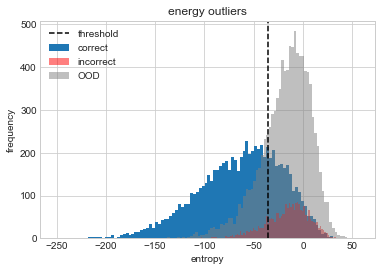

['exit_1']


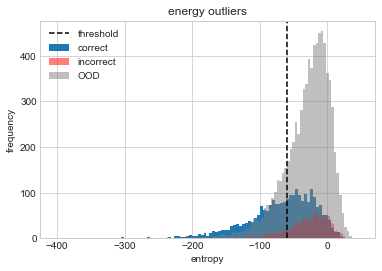

['exit_1', 'exit_2']


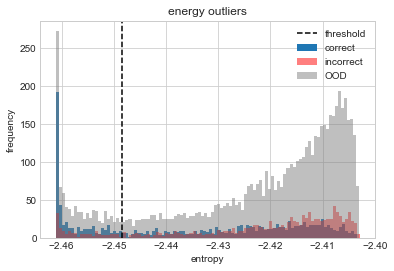

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7629 -34.996609         5926          2177              5476           0.731334             0.675799
1     exit_2       4074        7823         0.7760 -59.567696         1474          1349              1218           0.522140             0.431456
2  Main_exit       2600        6474         0.7798         NA         2600          6474              1366           0.286533             0.150540


In [23]:
evaluate.EvaluateOOD(output_ID,output_OOD,metrics=["energy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

In [21]:
# model.save("./models/journal_models/alexnet_EDL_ET15_n1.hdf5")

In [ ]:
# def save_outputs(filename,outputs):
#     from openpyxl import Workbook
#     wb= Workbook()
#     ws=wb.active
#     with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
#         writer.book=wb
#         writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

#         #useful code
#         for i, df in enumerate(outputs):
#             name = "exit{}".format(i+1)
#             df.to_excel(writer, name)
#         # df.to_excel(writer, sheet, ...)
#         writer.save()
#     wb.close()
    
# def read_outputs(fileName):
#     output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
#     # for i in output_test:
#         # print(i.head())
#     return output_test
# filename = 'wideresnet_Brev_conv3_5'
# save_outputs(filename+'_ID',output_ID)
# save_outputs(filename+'_OOD',output_OOD)
# # save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

tpr 0.9499935889216566 2231
calibration  lr_auc 0.8529236876615841 Best Threshold=0.4402243494987488, G-Mean=0.5547471514528431, TPR=0.9499935889216566, FPR=0.676056338028169


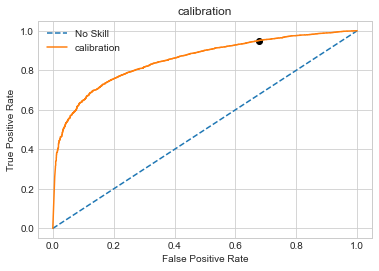

[0.44022435]
tpr 0.9498973305954825 3303
calibration  lr_auc 0.686759289279553 Best Threshold=0.6542484760284424, G-Mean=0.3313652769860345, TPR=0.9498973305954825, FPR=0.8844054580896686


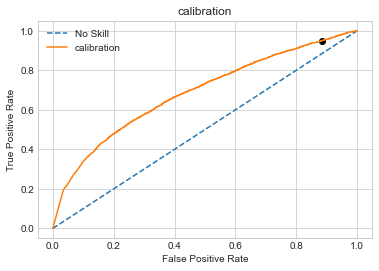

[0.6542485]
tpr 0.9501090909090909 507
calibration  lr_auc 0.6723376174545455 Best Threshold=0.9959756731987, G-Mean=0.4281740886389766, TPR=0.9501090909090909, FPR=0.80704


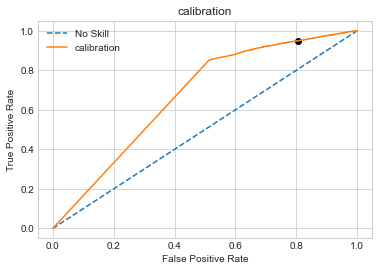

[0.9959757]
tpr 0.9935243868834389 1
calibration  lr_auc 0.5144428020168996 Best Threshold=1.0, G-Mean=0.18747415628136901, TPR=0.9935243868834389, FPR=0.9646243617797229


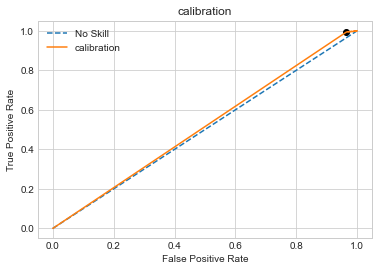

[1.0]
tpr 0.9664928292046936 1
calibration  lr_auc 0.5664099020205807 Best Threshold=1.0, G-Mean=0.40066078730222393, TPR=0.9664928292046936, FPR=0.8339055793991417


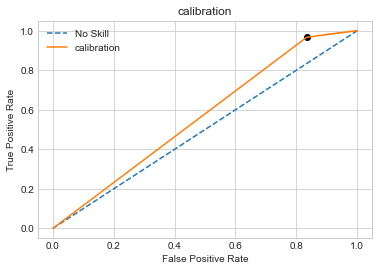

[1.0]
tpr 0.9499248873309964 2261
calibration  lr_auc 0.8579551422063513 Best Threshold=0.5598170161247253, G-Mean=0.5607480337345808, TPR=0.9499248873309964, FPR=0.668986083499006


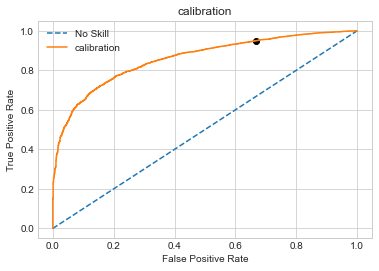

[0.559817]
tpr 0.9500247402276101 1910
calibration  lr_auc 0.862699742474374 Best Threshold=0.6397796869277954, G-Mean=0.5681463219599922, TPR=0.9500247402276101, FPR=0.6602296450939458


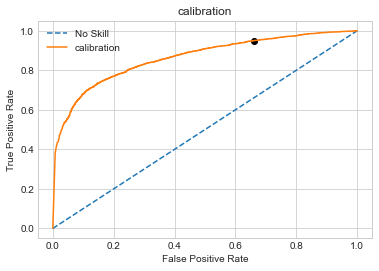

[0.6397797]


In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax

def findTpr95(output_df,metrics=['energy'],plot=False, pos_label = 0):
    ''' find a threshold value that returns a Total positive rate of 95
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx

    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        
        # sorted_data = output_df.sort_values(metric)
        # print(sorted_data)
        # correct = output_df.loc[output_df['correct'] == 1]
        # totalCorrect = len(correct)
        # tprLimit = int(totalCorrect * 0.95)
        # print(tprLimit)
        # metricMin = output_df[metric].min()
        # metricMax = output_df[metric].max()
        # print(metricMin, metricMax)
        # linSpace = np.linspace(metricMin, metricMax, 1000)
        # _tpr = 0 
        # for i in linSpace:
        #     _tpr = correct.loc[correct[metric] <= i]
        #     if len(_tpr) >= tprLimit:
        #         break
        # print("TPR95", len(_tpr), i)
        
        
        
        # print(linSpace)
        # print(totalCorrect)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        _tpr, ix = find_nearest(tpr,.95)
        print("tpr",_tpr, ix)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        # ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

for i in output_ID:
    print(findTpr95(i,'calibration',plot=True))
    # print(calc_AUC(i,'calibration',plot=True))
    

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def findTpr95(output_df,metrics=['energy'],plot=False, pos_label = 0):
    ''' find a threshold value that returns a Total positive rate of 95
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx

    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        _tpr, ix = find_nearest(tpr,.95)
        # print("tpr",_tpr, ix)
        # gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        # ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

    
    
    
def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'], rollover=True):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            if exit > 0: #if a specific exit number is specified, only output the results of that exit.
                _ID = [_ID[max(exit-1,0)]]
                _OOD = [_OOD[max(exit-1,0)]]
                exit_labels=['exit_{}'.format(exit)]

            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
             
                
                if threshold:
                    if type(threshold) is list:
                        if i >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[i]
                        print("threshold",_threshold)
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "TPR95":
                        # print("m",metric)
                        AUC_thresholds = findTpr95(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "gmean":
                        # print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if rollover:
                    if i > 0:
                        # if len(rollOver_ID_indices)>0:
                            # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                        # if len(rollOver_OOD_indices)>0:
                            # if plot:
                            # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    # else:
                            # output_ID = output_ID.iloc[rollOver_ID_indices]
                            # output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                        
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
  
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel(metric)
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    if len(ID_accepted) >0:
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    else:
                        accepted_ID_acc = 0
                        overall_accepted_acc = 0
                    
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                        if len(ID_accepted) >0:
                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        else:
                            accepted_ID_acc = 0
                            overall_accepted_acc = 0   
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN


                        if len(ID_accepted) >0:
                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    # print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                if (len(ID_accepted) + len(OOD_accepted)) > 0:
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                else:
                    Accepted_Ratio_list.append(0)
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


In [16]:
def load_outputs(filename,exits=['exit1','exit2','exit3']):
    result = list(pd.read_excel("./csv/"+filename,sheet_name=exits).values())
    return result

# output_ID = pd.read_excel("./csv/alexnet_B_conv3_5_test.h5_ID.xlsx",sheet_name=exits)
# output_OOD = pd.read_excel("./csv/alexnet_B_conv3_5_test.h5_OOD.xlsx",sheet_name=['exit1','exit2','exit3'])

output_ID = load_outputs("alexnet_B_Bconv_5_ID.xlsx",exits =['exit1','exit2','exit3'])

output_OOD = load_outputs("alexnet_B_Bconv_5_OOD.xlsx",exits =['exit1','exit2','exit3'])

In [53]:
#### CDL 
buildComparePlot(output_ID, output_OOD, ["energy"], "PR_AUC", exit=-1,  main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "mean", exit=-1,  main_exit_included=False,plot=False)
# buildComparePlot(output_ID, output_OOD, ["calibration"], "mean", exit=-1,  main_exit_included=False,plot=False)

metric:  energy threshold:  PR_AUC
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.4870  -2.460480         5131          4415              3166           0.537503             0.331657
1    exit_2       4869        5585         0.6876  -2.415938         4867          5584              3097           0.465697             0.296335
2    exit_3          2           1         0.7258  -2.424592            2             1                 0           0.666667             0.000000
3    exit_4          0           0         0.7670  -2.424584            0             0                 0           0.000000             0.000000
4    exit_5          0           0         0.7988  -2.461056            0             0                 0           0.000000             0.000000
5    exit_6          0           0         0.8084  -2.404790            0             0  

metric:  calibration threshold:  PR_AUC
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.4870   0.997056         4870          4114              3041           0.542075             0.338491
1    exit_2       5130        5886         0.6875   1.000000         3572          3315              2643           0.518658             0.383767
2    exit_3       1558        2571         0.7258   1.000000         1524          2469               816           0.381668             0.204358
3    exit_4         34         102         0.7670   1.000000           27            88                16           0.234783             0.139130
4    exit_5          7          14         0.7988   0.701264            3             2                 2           0.600000             0.400000
5    exit_6          4          12         0.8084   0.830682            0           

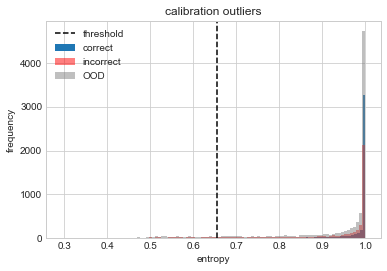

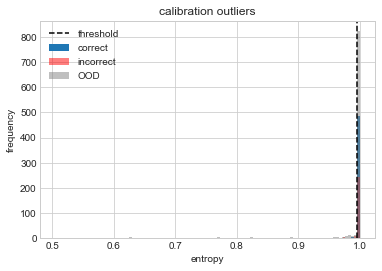

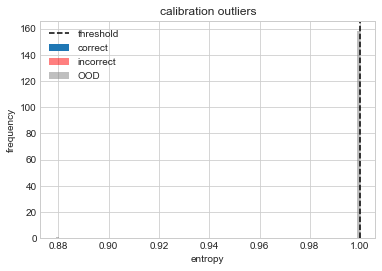

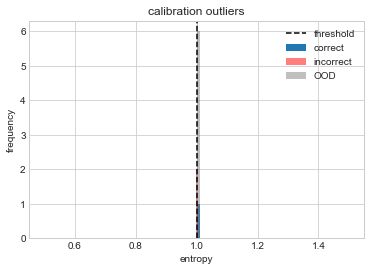

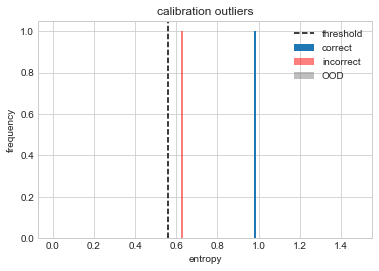

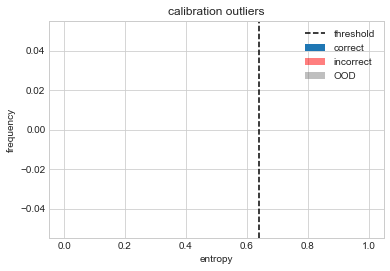

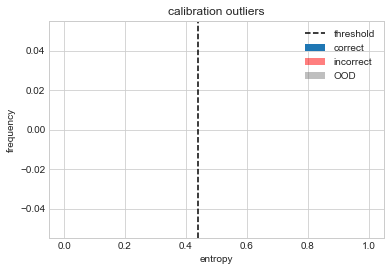

  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.4870   0.654248         9163          9021              4626           0.503905             0.254399
1    exit_2        837         979         0.6875   0.995976          726           820               486           0.469599             0.314360
2    exit_3        111         159         0.7258   1.000000          107           153                53           0.411538             0.203846
3    exit_4          4           6         0.7670   1.000000            2             6                 1           0.250000             0.125000
4    exit_5          2           0         0.7988   0.559817            2             0                 1           1.000000             0.500000
5    exit_6          0           0         0.8084   0.639780            0             0                 0           0.000000

In [59]:
#### CDL 
buildComparePlot(output_ID, output_OOD, ["calibration"], "PR_AUC", exit=-1,  main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", exit=-1,  main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["calibration"], "mean", exit=-1,  main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["calibration"], "TPR95", exit=-1,  main_exit_included=False,plot=True)
# buildComparePlot(output_ID, output_OOD, ["calibration"], "mean", exit=-1,  main_exit_included=False,plot=False)

metric:  entropy threshold:  gmean


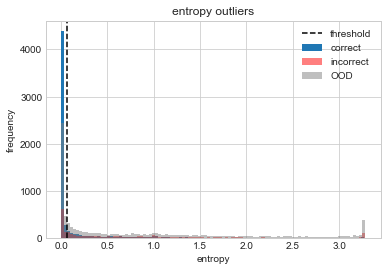

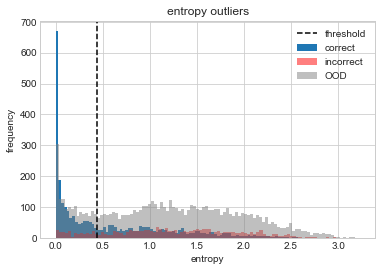

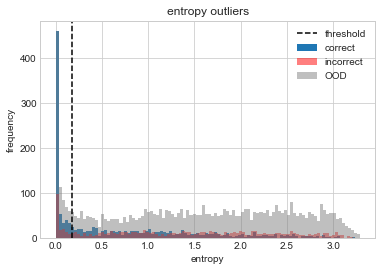

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6667  0.062831         5408          2877              4664           0.652746             0.562945
1     exit_2       4592        7123         0.7713  0.436796         1910          1495              1678           0.560940             0.492805
2  Main_exit       2682        5628         0.7960        NA         2682          5628              1537           0.322744             0.184958
metric:  calibration threshold:  gmean
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6667  0.230865         5333          2808              4614           0.655079             0.566761
1     exit_2       4667        7192         0.7713  0.214996         2060  

In [35]:
### CE
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", exit=-1,  main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", exit=-1,  main_exit_included=True,plot=False)
# buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  energy threshold:  gmean


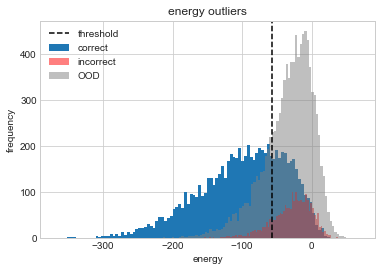

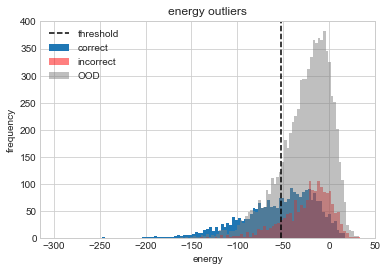

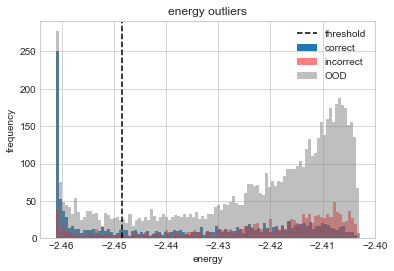

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7666 -57.499893         5778          2210              5403           0.723335             0.676390
1     exit_2       4222        7790         0.7728 -52.414265         1424          1270              1168           0.528582             0.433556
2  Main_exit       2798        6520         0.7798         NA         2798          6520              1480           0.300279             0.158832


In [20]:
### EDL + IAR e15 g100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=True,plot=True)
# buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  energy threshold:  gmean


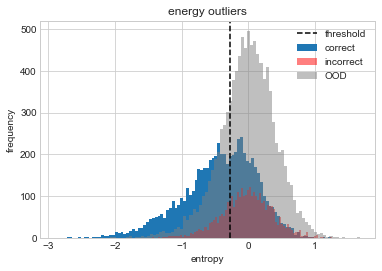

['exit_1', 'exit_2', 'exit_3']


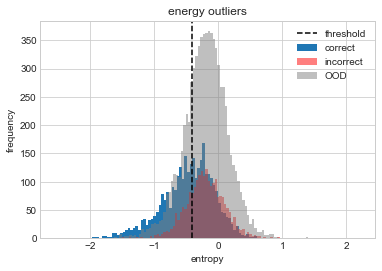

['exit_1', 'exit_2', 'exit_3']


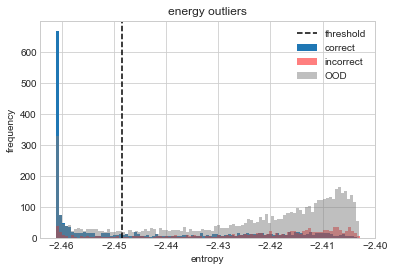

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.6649  -0.274016         4616          2433              3797           0.654845             0.538658
1    exit_2       5384        7567         0.6944  -0.407209         2178          1856              1662           0.539911             0.411998
2    exit_3       3206        5711         0.7799  -2.448426         1278           977              1116           0.566741             0.494900
metric:  energy threshold:  gmean


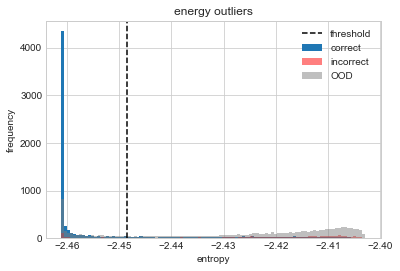

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000         0.7799  -2.448426         6122          2199              5741           0.735729             0.689941


In [33]:
#### MAEB no regualizer, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean


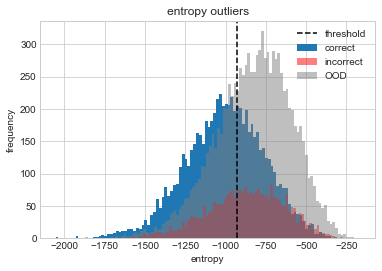

['exit_1', 'exit_2', 'exit_3']


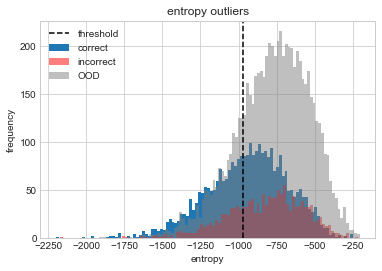

['exit_1', 'exit_2', 'exit_3']


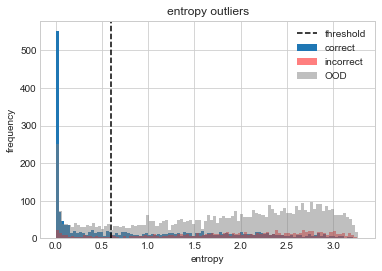

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7116 -926.829041         5521          3201              4382           0.632997             0.502408
1    exit_2       4479        6799         0.7631 -972.125977         1687          1389              1297           0.548440             0.421651
2    exit_3       2792        5410         0.7799    0.594663         1071           873               952           0.550926             0.489712
metric:  entropy threshold:  gmean


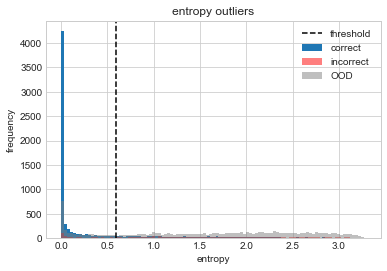

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000         0.7799   0.594663         6190          2250              5786           0.733412             0.685545


In [25]:
#### EDL no regualizer, frozen, entropy
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", exit=-1,  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  energy threshold:  gmean


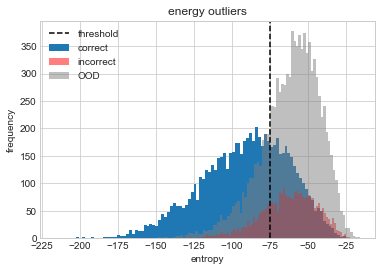

['exit_1', 'exit_2', 'exit_3']


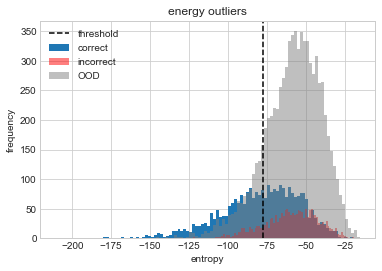

['exit_1', 'exit_2', 'exit_3']


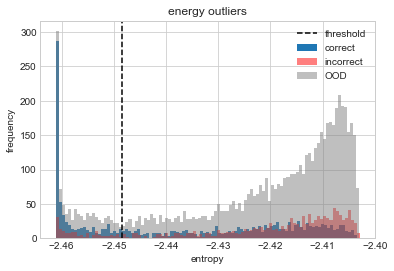

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7116 -74.867752         5554          2186              4852           0.717571             0.626873
1    exit_2       4446        7814         0.7631 -77.117447         1633          1206              1360           0.575203             0.479042
2    exit_3       2813        6608         0.7799  -2.448426          777           999               622           0.437500             0.350225
metric:  energy threshold:  gmean


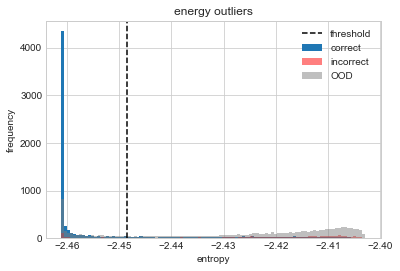

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000         0.7799  -2.448426         6122          2199              5741           0.735729             0.689941


In [21]:
#### EDL no regualizer, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  energy threshold:  gmean


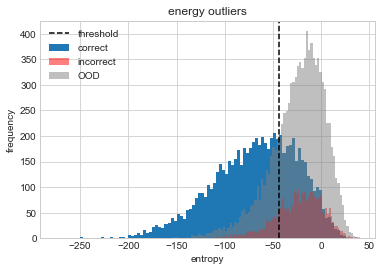

['exit_1']


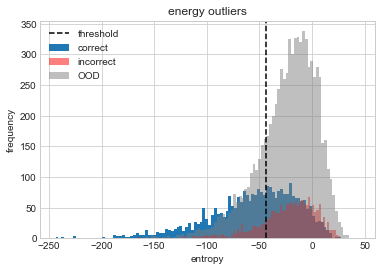

['exit_1', 'exit_2']


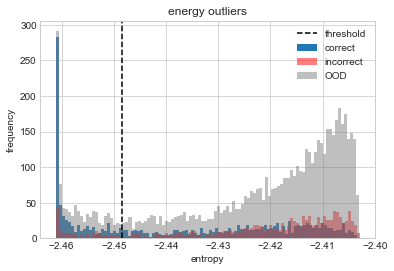

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7105 -43.385307         5353          2189              4806           0.709759             0.637232
1    exit_2       4647        7811         0.7579 -44.142563         1903          1589              1577           0.544960             0.451604
2    exit_3       2744        6222         0.7799  -2.448426          774           997               618           0.437041             0.348955
metric:  energy threshold:  gmean


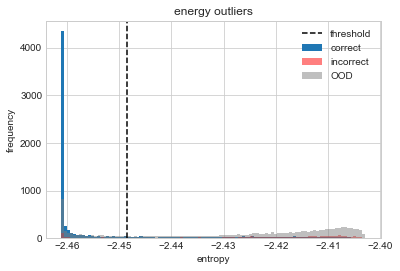

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000         0.7799  -2.448426         6122          2199              5741           0.735729             0.689941


In [15]:
#### Info_regualizer, growth 100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

metric:  energy threshold:  gmean


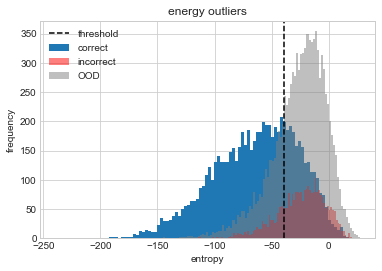

['exit_1', 'exit_2', 'exit_3']


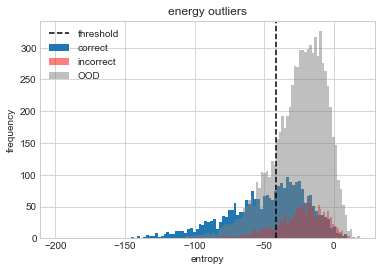

['exit_1', 'exit_2', 'exit_3']


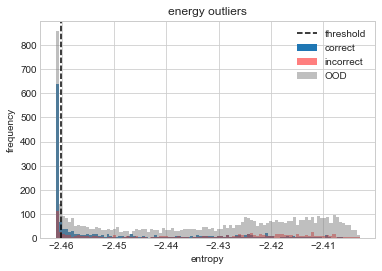

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7186 -39.259869         5745          2427              5113           0.703010             0.625673
1    exit_2       4255        7573         0.7680 -41.430023         1629          1406              1354           0.536738             0.446129
2    exit_3       2626        6167         0.8208  -2.460134          823           967               690           0.459777             0.385475
metric:  energy threshold:  gmean


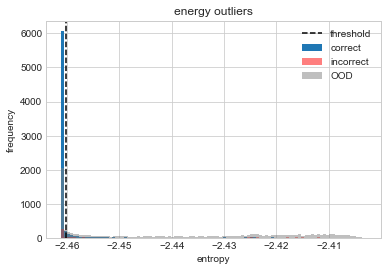

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000         0.8208  -2.460134         6545          2239              6230           0.745105             0.709244


In [21]:
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", exit=3,  main_exit_included=False,plot=False)
# buildComparePlot(output_ID, output_OOD, ["entropyOld"], "gmean", exit=3,  main_exit_included=False,plot=True)

#### ALP regularizer
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=-1,  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3,  main_exit_included=False,plot=True)

In [99]:
#old entropy, not base 2.
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean",  main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropyOld"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.19577276764843385 Best Threshold=3.2190940380096436, G-Mean=0.7331541495569829, TPR=0.7603225806451613, FPR=0.29304347826086957
['exit_1']
m entropy
metric entropy
entropy  lr_auc 0.15294698849897112 Best Threshold=3.2368240356445312, G-Mean=0.7722442588478408, TPR=0.8078994614003591, FPR=0.2618373648996397
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15752898674669444 Best Threshold=3.216064929962158, G-Mean=0.7877415827565992, TPR=0.8296296296296296, FPR=0.2520315342631898
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6900  3.219094         5622          2783              4878           0.668888             0.580369
1     exit_2       4378        7217         0.7772  3.236824         1933          1748              1672           0.525129       

### T/F in distribution performance
<hr>

metric:  energy threshold:  gmean


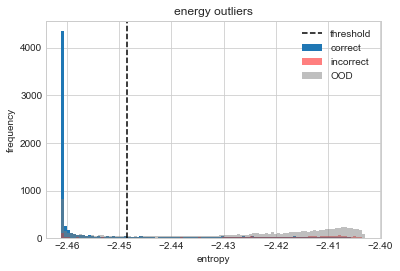

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7798  -2.448438         6122          2198              5741           0.735817             0.690024
metric:  entropy threshold:  gmean
['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7798   3.240947         6127          2206              5745           0.735269             0.689428


In [18]:
#no branches, baseline OOD performance
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",  main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=False)

In [25]:
#branches, CE OOD performance
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean" , main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)

# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.19414371201496028 Best Threshold=0.09101656824350357, G-Mean=0.7340748089615527, TPR=0.7677419354838709, FPR=0.2981159420289855
['exit_1', 'exit_2', 'exit_3']
m entropy
metric entropy
entropy  lr_auc 0.1542302224714969 Best Threshold=0.35475438833236694, G-Mean=0.7722418658187148, TPR=0.8491921005385996, FPR=0.297735460627895
['exit_1', 'exit_2', 'exit_3']
m entropy
metric entropy
entropy  lr_auc 0.1401877335655383 Best Threshold=0.003779303515329957, G-Mean=0.7876065984874147, TPR=0.811965811965812, FPR=0.23602183141297756
['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.6900   0.091017         5564          2709              4843           0.672549             0.585398
1    exit_2       4436        7291         0.7772   0.354754         

In [17]:
#branches, EDL OOD performance
# buildComparePlot(output_ID, output_OOD, ["energy"], "gmean" , main_exit_included=False,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=False)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.2218349539571125 Best Threshold=-73.56695556640625, G-Mean=0.7069716890821616, TPR=0.7543800539083558, FPR=0.33745733788395904
['exit_1']
m energy
metric energy
energy  lr_auc 0.22702653072500414 Best Threshold=-73.9314956665039, G-Mean=0.6976542366299335, TPR=0.7581602373887241, FPR=0.3580230010952902
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.1393570800373329 Best Threshold=-2.460134744644165, G-Mean=0.7912132723692736, TPR=0.8247767857142857, FPR=0.24098440545808966
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7032 -73.566956         5389          2094              4659           0.720166             0.622611
1     exit_2       4611        7906         0.7304 -73.931496         1427          1187              1089           0.545907             0.

metric:  energy threshold:  gmean


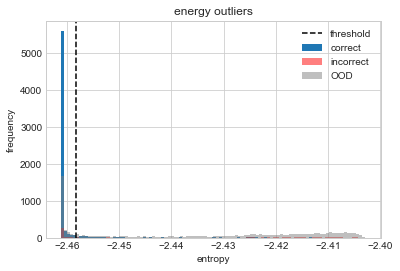

['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000          0.796  -2.458297         6460          2253              6065           0.741421             0.696086
metric:  entropy threshold:  gmean
['exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_3      10000       10000          0.796   3.221582         6460          2253              6065           0.741421             0.696086
metric:  entropy threshold:  gmean
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.6667   3.217617         5334          28

In [24]:
#branches, CE OOD performance
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", exit=3, main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", exit=3, main_exit_included=False,plot=False)

buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=False)

metric:  energy threshold:  gmean


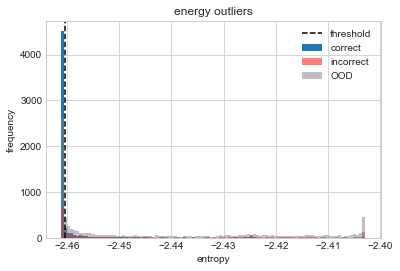

['exit_1', 'exit_2', 'exit_3']


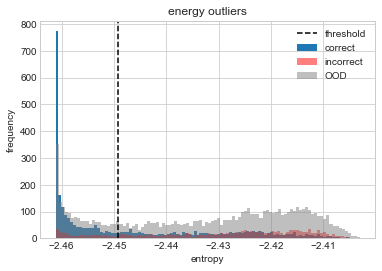

['exit_1', 'exit_2', 'exit_3']


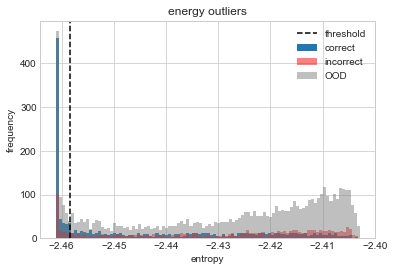

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.6667  -2.460334         5334          2808              4614           0.655122             0.566691
1    exit_2       4666        7192         0.7713  -2.449207         2063          1756              1792           0.540194             0.469233
2    exit_3       2603        5436         0.7960  -2.458297          757           736               603           0.507033             0.403885


In [26]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.20219875738550666 Best Threshold=-63.33218002319336, G-Mean=0.7220498930700966, TPR=0.7703332139018273, FPR=0.32320710223331944


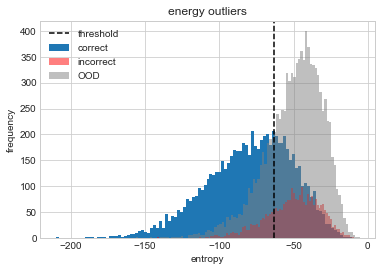

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.18010309327686558 Best Threshold=-73.96076202392578, G-Mean=0.7439953341957053, TPR=0.786833855799373, FPR=0.2965108793614008


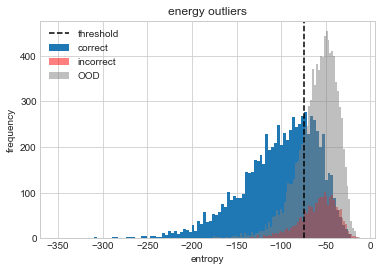

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.14866306151040815 Best Threshold=-2.4484262466430664, G-Mean=0.7804036013610229, TPR=0.8273512039981826, FPR=0.263879984613412


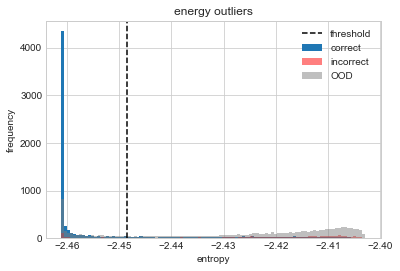

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7209  -63.33218         5521          2207              4879           0.714415             0.631341
1     exit_2       4479        7793         0.7767 -73.960762         1668          1443              1415           0.536162             0.454838
2  Main_exit       2811        6350         0.7799         NA         2811          6350              1558           0.306844             0.170069


In [35]:
#EDL e15, no kl, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.19578976046697213 Best Threshold=3.217616558074951, G-Mean=0.7367305893689534, TPR=0.7842784278427842, FPR=0.3079346032698365


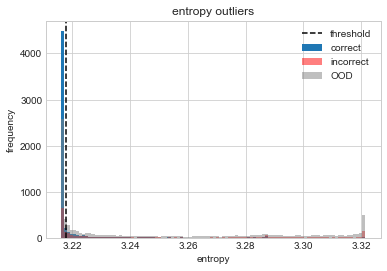

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15787838759212142 Best Threshold=3.239302635192871, G-Mean=0.7701934148380185, TPR=0.7940533449934412, FPR=0.25294956566835214


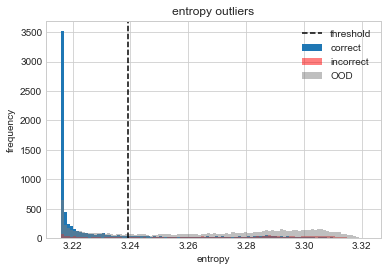

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1496894706375012 Best Threshold=3.221587657928467, G-Mean=0.7840769746256688, TPR=0.8068627450980392, FPR=0.23806532663316582


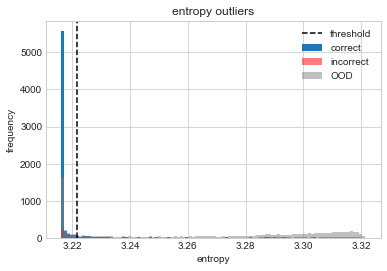

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6667  3.217617         5334          2808              4614           0.655122             0.566691
1     exit_2       4666        7192         0.7713  3.239303         2067          1766              1795           0.539264             0.468302
2  Main_exit       2599        5426         0.7960        NA         2599          5426              1487           0.323863             0.185296


In [46]:
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.1937686501847382 Best Threshold=-58.925376892089844, G-Mean=0.7379733500328961, TPR=0.7731063238359972, FPR=0.2955630440887391


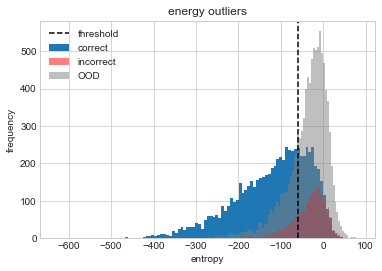

['exit_1', 'exit_2']
energy  lr_auc 0.16313478102686396 Best Threshold=-39.291954040527344, G-Mean=0.7680299234407751, TPR=0.8015267175572519, FPR=0.2640669981680188


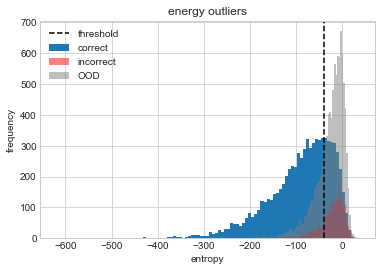

['exit_1', 'exit_2']
energy  lr_auc 0.14866306151040815 Best Threshold=-2.4484262466430664, G-Mean=0.7804036013610229, TPR=0.8273512039981826, FPR=0.263879984613412


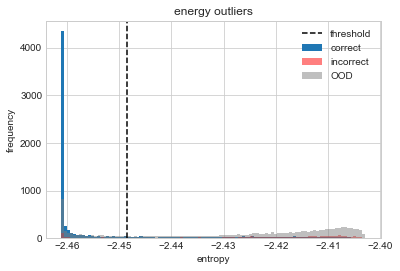

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7122 -58.925377         5671          2507              5017           0.693446             0.613475
1     exit_2       4329        7493         0.7642 -39.291954         1784          1588              1511           0.529063             0.448102
2  Main_exit       2545        5905         0.7799         NA         2545          5905              1387           0.301183             0.164142


In [69]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.18363186589468064 Best Threshold=-46.91735076904297, G-Mean=0.7372800333543142, TPR=0.7938689217758985, FPR=0.3152750628316113


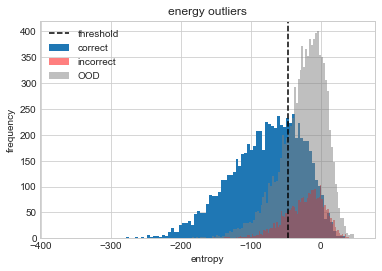

['exit_1', 'exit_2']
energy  lr_auc 0.16401642220225462 Best Threshold=-35.95215606689453, G-Mean=0.7584720776213465, TPR=0.7925894378194208, FPR=0.274176685833769


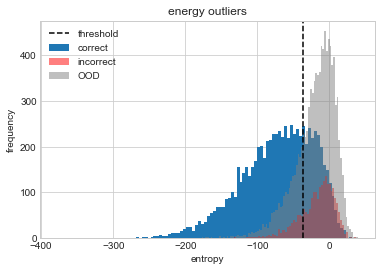

['exit_1', 'exit_2']
energy  lr_auc 0.14866306151040815 Best Threshold=-2.4484262466430664, G-Mean=0.7804036013610229, TPR=0.8273512039981826, FPR=0.263879984613412


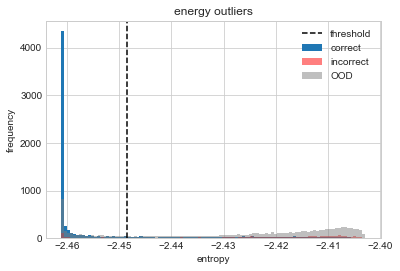

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7162 -46.917351         5490          2247              4904           0.709577             0.633837
1     exit_2       4510        7753         0.7652 -35.952156         1814          1559              1515           0.537800             0.449155
2  Main_exit       2696        6194         0.7799         NA         2696          6194              1490           0.303262             0.167604
metric:  uncert threshold:  gmean
uncert  lr_auc 0.18658722952297568 Best Threshold=0.08333007246255875, G-Mean=0.7372395938937051, TPR=0.7928118393234672, FPR=0.3144373080145211


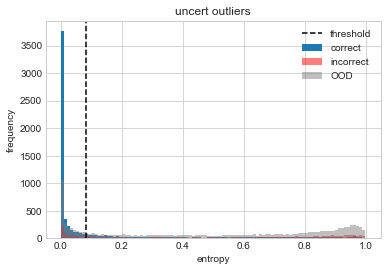

['exit_1', 'exit_2']
uncert  lr_auc 0.16577153894584798 Best Threshold=0.23774874210357666, G-Mean=0.7581306294265814, TPR=0.7793867120954003, FPR=0.2625457396759017


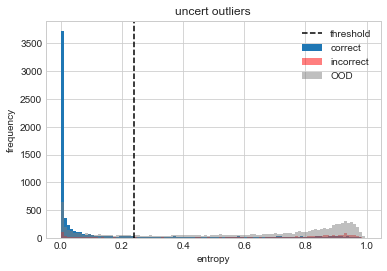

['exit_1', 'exit_2']
uncert  lr_auc 0.14990886714760143 Best Threshold=0.4974072277545929, G-Mean=0.7801316837216322, TPR=0.8273512039981826, FPR=0.26439287088088215


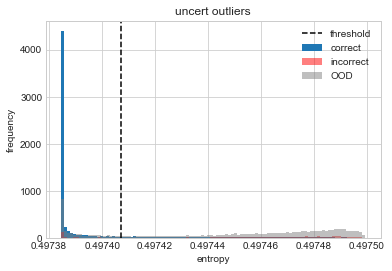

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7162   0.08333         5499          2260              4910           0.708725             0.632814
1     exit_2       4501        7740         0.7652  0.237749         1871          1653              1556           0.530931             0.441544
2  Main_exit       2630        6087         0.7799        NA         2630          6087              1442           0.301709             0.165424


In [50]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19198910391262908 Best Threshold=0.15438254177570343, G-Mean=0.7340142848031127, TPR=0.7709851124485271, FPR=0.3011836913634371


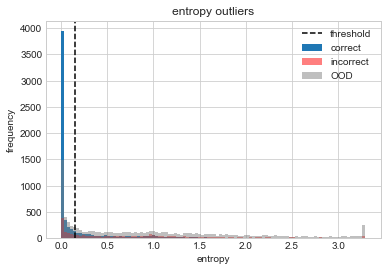

['exit_1', 'exit_2']
entropy  lr_auc 0.16153826176420644 Best Threshold=0.5896353721618652, G-Mean=0.7674024600004584, TPR=0.8189845474613686, FPR=0.28093083387201034


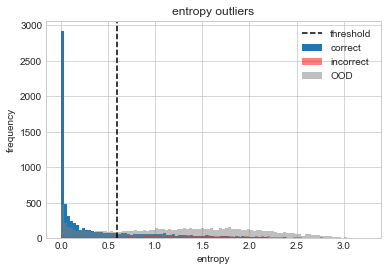

['exit_1', 'exit_2']
entropy  lr_auc 0.14844034862983807 Best Threshold=3.2409493923187256, G-Mean=0.7804610413587446, TPR=0.8268968650613358, FPR=0.2633670983459418


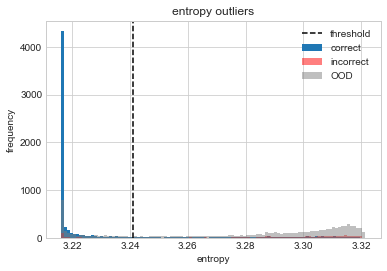

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6843  0.154383         5506          2586              4782           0.680425             0.590954
1     exit_2       4494        7414         0.7735  0.589635         1899          1559              1649           0.549161             0.476865
2  Main_exit       2595        5855         0.7799        NA         2595          5855              1438           0.307101             0.170178
metric:  calibration threshold:  gmean
calibration  lr_auc 0.8069260180978406 Best Threshold=0.9822301864624023, G-Mean=0.7335731845023978, TPR=0.6937015928686249, FPR=0.22426354133671206


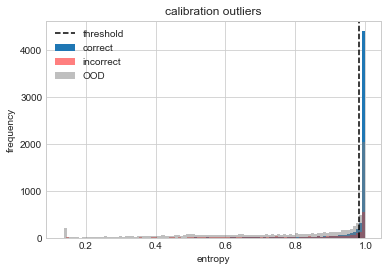

['exit_1', 'exit_2']
calibration  lr_auc 0.8409609427061706 Best Threshold=0.881438672542572, G-Mean=0.7705122525188368, TPR=0.7388493859082095, FPR=0.19646799116997793


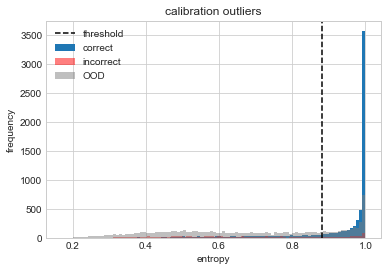

['exit_1', 'exit_2']
calibration  lr_auc 0.8530579678576902 Best Threshold=0.213678777217865, G-Mean=0.7803931131597074, TPR=0.7365046800871906, FPR=0.17310313493866425


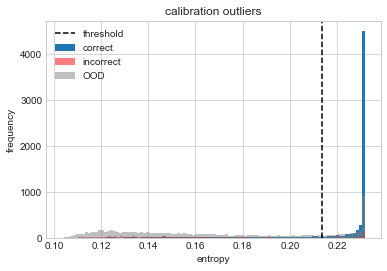

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6843   0.98223         5455          2551              4747           0.681364             0.592930
1     exit_2       4545        7449         0.7735  0.881439         2046          1774              1765           0.535602             0.462042
2  Main_exit       2499        5675         0.7799        NA         2499          5675              1369           0.305725             0.167482


In [58]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=True)

In [36]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=False)
# evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",plot=True)

metric:  energy threshold:  gmean


KeyError: 'e'

In [20]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.5721           0.572100 -22.218592      4280              3354        0.428000             0.783645
1     exit_2         5720         0.6850           0.574301 -33.497059       664               607        0.116084             0.914157
2  Main_exit         5056         0.8080           0.717563  -2.405431      5056              3628        1.000000             0.717563
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.5721           0.572100 -25.972778      3154              2640        0.315400             0.837032
1     exit_2         6846       

### ID/OOD branch performance
<hr>

In [54]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=False)


# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  energy threshold:  PR_AUC
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.4419   0.168403         5582          4436              3999           0.557197             0.399181
1     exit_2       4418        5564         0.8145 -13.578604          750            35               744           0.955414             0.947771
2  Main_exit       3668        5529         0.8648         NA         3668          5529              3002           0.398826             0.326411
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.4419   -5.57186         2229           466              2106           0.8270

In [ ]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6186  -23.82761         3815          1707              3233           0.690873             0.585476
1     exit_2       6185        8293         0.6842 -28.898783         1039           464               946           0.691284             0.629408
2  Main_exit       5146        7829         0.7229         NA         5146          7829              2975           0.396609             0.229287


In [13]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [14]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7629 -34.996609         5926           223              5476           0.963734             0.890551
1     exit_2       4074         777         0.7759 -59.582932         1474           130              1218           0.918953             0.759352
2  Main_exit       2600         647         0.7799         NA         2600           647              1367           0.800739             0.421004
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.7629 -34.996609         5926           457              5476           0.928404      

In [18]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.6900  3.219094         5622           291              4878           0.950786             0.824962
1     exit_2       4378         709         0.7772  3.236824         1933           166              1672           0.920915             0.796570
2  Main_exit       2445         543         0.8245        NA         2445           543              1478           0.818273             0.494645
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.6900  3.219094         5622           584              4878           0.905898 

In [21]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
energy  lr_auc 0.18363186589468064 Best Threshold=-46.91735076904297, G-Mean=0.7372800333543142, TPR=0.7938689217758985, FPR=0.3152750628316113
['exit_1', 'exit_2']
energy  lr_auc 0.16401642220225462 Best Threshold=-35.95215606689453, G-Mean=0.7584720776213465, TPR=0.7925894378194208, FPR=0.274176685833769
['exit_1', 'exit_2']
energy  lr_auc 0.14866306151040815 Best Threshold=-2.4484262466430664, G-Mean=0.7804036013610229, TPR=0.8273512039981826, FPR=0.263879984613412
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7162 -46.917351         5490           230              4904           0.959790             0.857343
1     exit_2       4510         770         0.7652 -35.952156         1814           153              1515           0.922217             0.770208
2  Main_exit       2696         617    

## Entropy Branch version
Now we build a branched model with the entropy metric and cross entropy loss for comparision.
<hr>

In [55]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])

model.summary()


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000016FCBBD7388>

preset: Other
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                               

In [56]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=True,callbacks=[lambda_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 278s 195ms/step - loss: 2.4611 - dense_3_loss: 0.1722 - branch_exit_loss: 1.1862 - branch_exit_1_loss: 0.7447 - dense_3_accuracy: 0.9417 - branch_exit_accuracy: 0.6133 - branch_exit_1_accuracy: 0.7422 - val_loss: 1.9256 - val_dense_3_loss: 0.1696 - val_branch_exit_loss: 0.8319 - val_branch_exit_1_loss: 0.5699 - val_dense_3_accuracy: 0.9412 - val_branch_exit_accuracy: 0.7062 - val_branch_exit_1_accuracy: 0.8080
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 276s 196ms/step - loss: 1.6505 - dense_3_loss: 0.1219 - branch_exit_loss: 0.7380 - branch_exit_1_loss: 0.4402 - dense_3_accuracy: 0.9618 - branch_exit_accuracy: 0.7438 - branch_exit_1_accuracy: 0.8479 - val_loss: 1.7529 - val_dense_3_loss: 0.1534 - val_branch_exit_loss: 0.7498 - val_branch_exit_1_loss: 0.5030 - val_dense_3_accuracy: 0.9468 - val_br

In [57]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 59ms/step - loss: 1.9134 - dense_3_loss: 0.4517 - branch_exit_loss: 0.6131 - branch_exit_1_loss: 0.5233 - dense_3_accuracy: 0.8630 - branch_exit_accuracy: 0.7911 - branch_exit_1_accuracy: 0.8391


[1.9133697748184204,
 0.45171138644218445,
 0.6130933165550232,
 0.5233008861541748,
 0.8629999756813049,
 0.791100025177002,
 0.8391000032424927]

In [58]:
model.save("./models/journal_models/wideresnet_B_conv3_5.hdf5")

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [59]:
output_ID_old= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID_old:
    i['outlier']=0


outputs 3


In [60]:
output_OOD_old = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD_old:
    i['correct']=0
    i['outlier']=1

outputs 3


In [63]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'wideresnet_B_conv3_5'
save_outputs(filename+'_ID',output_ID_old)
save_outputs(filename+'_OOD',output_OOD_old)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

metric:  energy threshold:  mean
['exit_1', 'exit_2']
3766 inputs accepted 3546 Correct


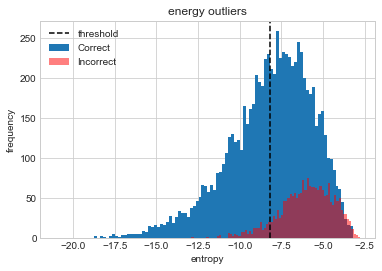

-----------------
rollover enabled, 6234 predictions provided
['exit_1', 'exit_2']
890 inputs accepted 856 Correct


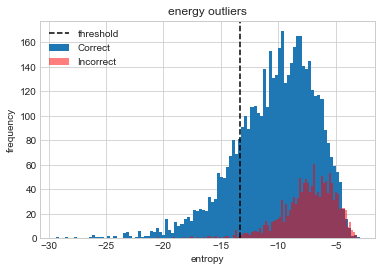

-----------------
rollover enabled, 5344 predictions provided
main_exit
5344 inputs accepted 4133 Correct


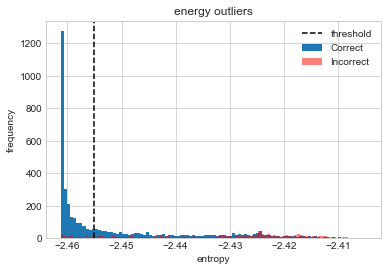

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100  -8.180323      3766              3546        0.376600             0.941583
1     exit_2         6234         0.8391           0.769811 -13.332321       890               856        0.142765             0.961798
2  Main_exit         5344         0.8630           0.773391  -2.455151      5344              4133        1.000000             0.773391


In [64]:
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["energy"],main_exit_included=True,plot=True)


In [67]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)


metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.082291      2090              2074        0.209000             0.992344
1     exit_2         7910         0.8391           0.798609   0.000280       467               467        0.059039             1.000000
2  Main_exit         7443         0.8630           0.817815   3.216030      7443              6087        1.000000             0.817815
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.575167      5029              4821        0.502900             0.958640
1     exit_2         4971     

### ID/OOD branch performance
<hr>

In [66]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.082291         2090           198              2074           0.913462             0.906469
1     exit_2       7910        9802         0.8391   0.00028          467            31               467           0.937751             0.937751
2  Main_exit       7443        9771         0.8630        NA         7443          9771              6087           0.432381             0.353608
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.575167         5029          1397              4821           

In [ ]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["entropy"], "mean",OOD_rate=[.1,.2,.5,1],plot=False)


### Calibration 
<hr>

In [ ]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["calibration"],main_exit_included=True,plot=False)


metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.614095      7911              6945        0.791100             0.877892
1     exit_2         2089         0.8391           0.626137   0.763845      1256               951        0.601245             0.757166
2  Main_exit          833         0.8630           0.579832   0.181627       833               483        1.000000             0.579832
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.866677      5553              5265        0.555300             0.948136
1     exit_2         4

In [69]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.614095         7911          5239              6945           0.601597             0.528137
1     exit_2       2089        4761         0.8391  0.763845         1256          1994               951           0.386462             0.292615
2  Main_exit        833        2767         0.8630        NA          833          2767               483           0.231389             0.134167
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.866677         5553          1932              5265   

In [74]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["calibration"], "mean",OOD_rate=[.1,.2,.5,1],plot=True)


NameError: name 'calc_auc_OOD' is not defined